*** 
<center><img src="https://cdn.iconscout.com/icon/free/png-256/free-insurance-1817174-1538042.png?f=webp&w=256" width=80 height=80 /></center>
<h1><center>Insurance Cross-Selling</center></h1>

**About the Dataset:**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Health Insurance Cross Sell Prediction Data dataset. 

The dataset is about an Insurance company that has provided Health Insurance to its customers.


**Content:**

id  | variable
-----|-------
1 | Gender 
2 | Age	
3 | Driving_License	
4 | Region_Code  
5 | Previously_Insured	
6 | Vehicle_Age
7 | Vehicle_Damage
8 | Annual_Premium
9 | Policy_Sales_Channel
10| Vintage	
11| Response



**Goal:**

The objective of this competition is to predict which customers respond positively to an automobile insurance offer. (i.e. whether they will accept or refuse the insurance offer);


***

### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix,\
ConfusionMatrixDisplay, classification_report

from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

import gc

### Load datasets

In [2]:
train_df=pd.read_csv("datasets/train.csv", index_col='id')
test_df=pd.read_csv("datasets/test.csv", index_col='id')
original_df = pd.read_csv('datasets/train_original.csv', index_col='id')

# Union both datasets
train_df_all = pd.concat([train_df,original_df])

In [4]:
print(f'Number of rows: {train_df_all.shape[0]} \nNumber of cols: {train_df_all.shape[1]}')

print('\n')

negative = train_df_all['Response'][train_df_all['Response'] == 0].count()
positive = train_df_all['Response'][train_df_all['Response'] == 1].count()

print(f'Negative: {negative}\nPositve: {positive}')

Number of rows: 11885907 
Number of cols: 11


Negative: 10424138
Positve: 1461769


In [5]:
train_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11885907 entries, 0 to 381109
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ GB


In [6]:
# Convert float columns to integer
train_df_all = train_df_all.apply(lambda dt: dt.astype(np.int64) if dt.dtype == 'float64' else dt)

test_df = test_df.apply(lambda dt: dt.astype(np.int64) if dt.dtype == 'float64' else dt)

In [4]:
train_df_all.describe().T.round(2).style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
Age,11885907.000000,38.400000,15.010000,20.000000,24.000000,36.000000,49.000000,85.000000
Driving_License,11885907.000000,1.000000,0.040000,0.000000,1.000000,1.000000,1.000000,1.000000
Region_Code,11885907.000000,26.420000,13.000000,0.000000,15.000000,28.000000,35.000000,52.000000
Previously_Insured,11885907.000000,0.460000,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Annual_Premium,11885907.000000,30464.670000,16479.610000,2630.000000,25256.000000,31820.000000,39450.000000,540165.000000
Policy_Sales_Channel,11885907.000000,112.410000,54.040000,1.000000,29.000000,151.000000,152.000000,163.000000
Vintage,11885907.000000,163.590000,80.120000,10.000000,98.000000,166.000000,232.000000,299.000000
Response,11885907.000000,0.120000,0.330000,0.000000,0.000000,0.000000,0.000000,1.000000


<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

## <center> Preliminary Insights </center>

#### **Response (Target Variable):** 
The mean is 0.12, which indicates that there are 12% of positive responses for the insurance offer. Also means that we are dealing with an imbalanced class. It might be a good ideia to preform undersampling

#### **Age:**
The age mean is 38.40 with standard deviation of 15.01 indicading that the age is moderately spreaded. Ranging from 20 to 85.


#### **Previously_Insured:**
Almost half of the data comes from people that was previously insured


### Rename columns and decode the data for the purpose of EDA

In [8]:
labels_txt =  {
            'Driving_License': {0:'No', 1:'Yes'},
            'Previously_Insured':{0:'No', 1:'Yes'},
            'Response':{0:'No', 1:'Yes'}              
             }

In [9]:
train_df_viz = train_df_all.copy()

# labeling the data based on the labels_txt dictionary
for num, label in labels_txt.items():
    for col in train_df_viz.columns:
        if col in num:
            train_df_viz[col] = train_df_viz[col].replace(label)  

In [10]:
# Check age distribution
#sns.histplot(train_df_all['Age']);

In [11]:
# Check vintage distribution
#sns.histplot(train_df_all['Vintage']);

In [12]:
# Create a age bucket
train_df_viz['Age group'] = ['20 - 30' if age <= 30 else '31 - 40' if age <= 40 else '41 - 50' if age <=50 else '51 - 60' \
                            if age <= 60 else '> 60' for age in train_df_viz['Age']]

In [13]:
# create a vintage bucket
train_df_viz['Vintage group'] = ['10 - 59' if vint <= 59 else '60 - 108' if vint <= 108 else '109 - 157' if vint <= 157 \
                                 else '158 - 203' if vint <= 196 else '204 - 249' if vint <= 245 else '250 - 299'\
                                 for vint in train_df_viz['Vintage']]

In [14]:
# create index to sort the age group 
train_df_viz['Age group_sort'] = train_df_viz['Age group'].apply(lambda age: 1 if age == '20 - 30' else 2 if age == '31 - 40'\
                                                                 else 3 if age == '41 - 50' else 4 if age == '51 - 60' else 5)

In [15]:
# create index to sort the vintage group 
train_df_viz['Vintage group_sort'] = train_df_viz['Vintage group'].apply(lambda vint: 1 if vint == '10 - 59' else 2 if vint == '60 - 108' else 3 \
                                                                         if vint == '109 - 157' else 4 if vint == '158 - 203' else 5\
                                                                         if vint == '204 - 249' else 6)

In [16]:
# Save it to a csv file
#train_df_viz.to_csv('datasets/train_df_viz.csv')

In [17]:
# Assign each column name to the corresponding type of variable
discrete_var = list(train_df_viz.select_dtypes('int').columns)[0:5]
categorical_var = list(train_df_viz.select_dtypes('object').columns)[0:5]

In [18]:
# Free up some memory
del original_df
del train_df_viz
del train_df

# Exploratory Data Analysis

### Check outliers

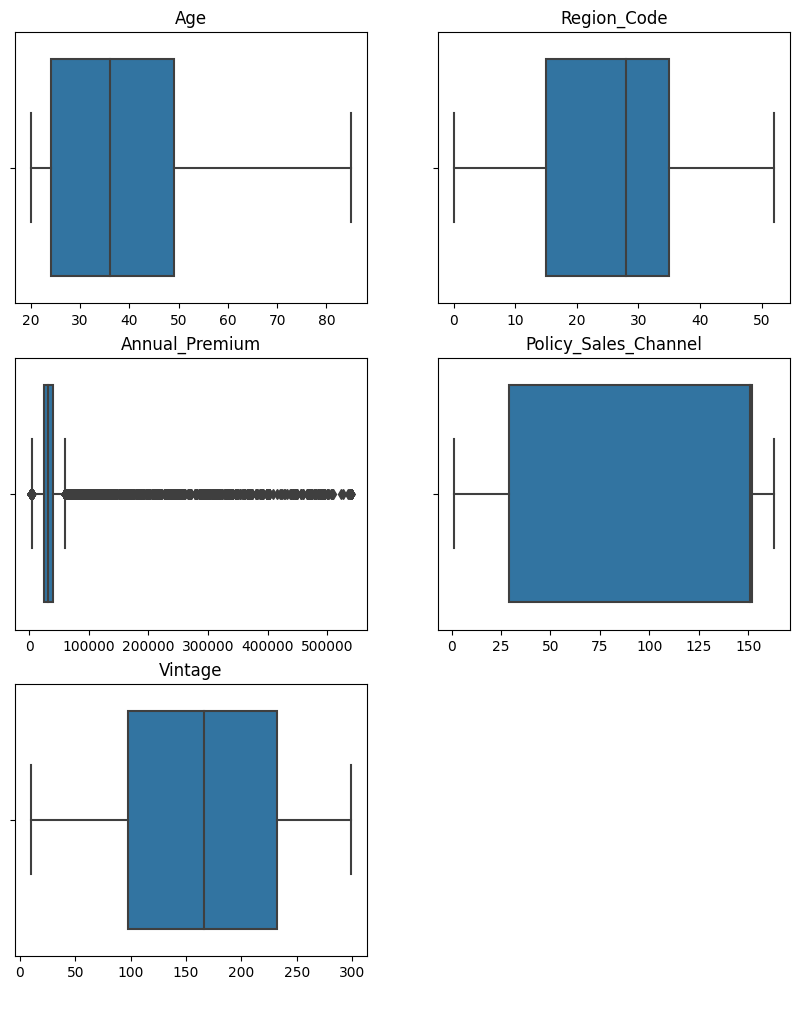

In [19]:
plt.figure(figsize=(10, 12))
plotnumber = 1

# Loop through each column
for col in discrete_var:
    if plotnumber <= len(discrete_var):
        plt.subplot(3, 2, plotnumber)
        ax = sns.boxplot(x=train_df_all[col])
        plt.title(col)
        plt.xlabel(' ')        
    plotnumber += 1

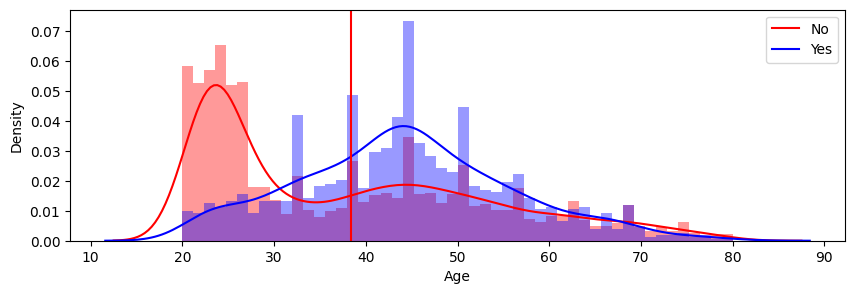

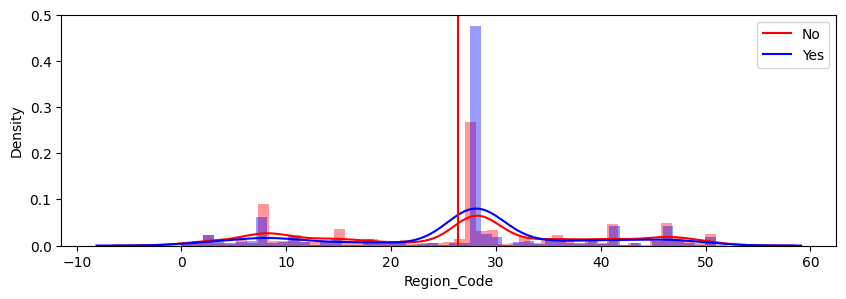

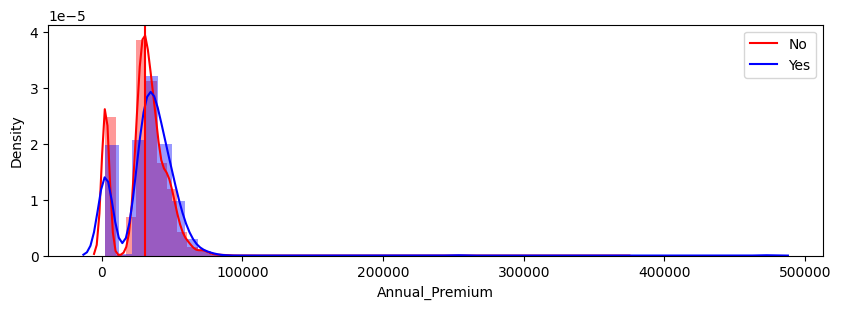

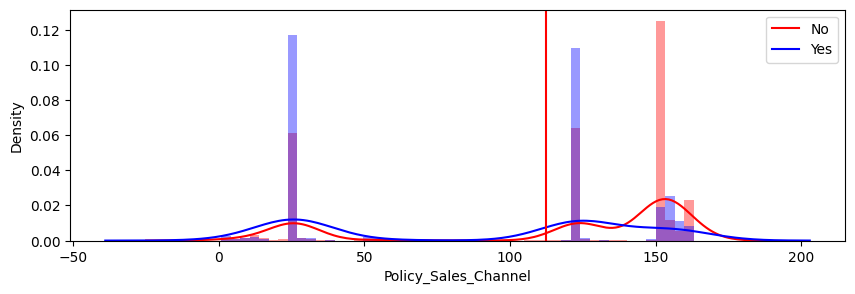

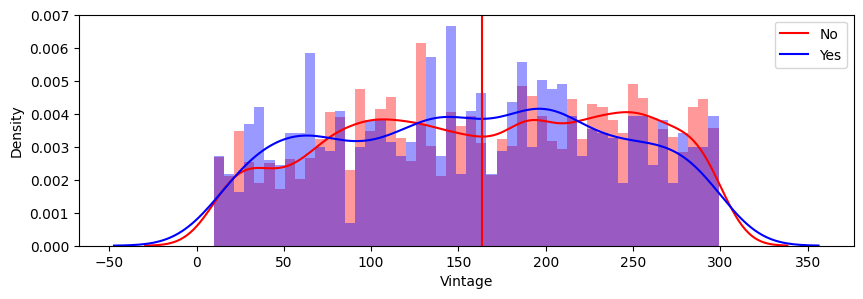

In [20]:
palette=['red', 'blue']

# get a random sample of the data
sample = train_df_all.sample(10000)

for num_var in discrete_var:    

    plt.figure(figsize=(10, 3))   
    
    # Histograms    
    sns.distplot(sample[num_var][sample['Response'] == 0], color = 'red', bins=50) 
    sns.distplot(sample[num_var][sample['Response'] == 1], color = 'blue', bins = 50) 
    plt.axvline(np.mean(train_df_all[num_var]), color="red")  
    plt.legend(['No','Yes'])


## Power BI Viz
### [Insurance Cross-Selling](https://app.powerbi.com/view?r=eyJrIjoiZjYxYTA4ZGItNGFhMC00ZjJlLWJiNmYtNTI4MmQ3ZjkyYjgzIiwidCI6IjhkODQwNjdkLTlhZDctNDU3Mi05YjEwLTEzM2QzNjQ2MmFhYSIsImMiOjF9)

<img src="https://i.ibb.co/PgRJWsW/2024-07-15-16-35-30-Insurance-Cross-Selling.png" width=1000 height=500/>




<img src="https://i.ibb.co/pnNRQLc/2024-07-15-16-35-47-Insurance-Cross-Selling.png" width=1000 height=500/>





<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

## <center>Insights </center>

#### **Gender:** 
Males are more likely to responde positive for the insurance offer than women (14% and 10% respectively);

#### **Region**
Region 28 and 38 have the highest relative response (19% responded Yes). Although Region 38 has just 63k offers.
They are followed by 8, 46, 41, 29, etc (9%, 10%, 11% and 12% respectively).

#### **Age Group**
People between 20 - 30 has the highest number of offers, but the lowest positive response (Offers 5M, response 4%).
The people with more positive responses are between 31 to 50 (21%)

#### **Previously Insured:**
23% of people who weren't previously insured responded positively to the offer;

#### **Vehicle Damaged:**
24% for those that the vehicle was damaged responded positively; 

#### **Vehicle Age:**
18% for those that the vehicle age was 1 to 2 years responded positively;


#### Positive Response:
    Gender (Male):  14%
    Region (28): 19%
    Age Group (20 - 30) 21%
    Vehicle Damaged (Yes) - 24%
    Previously Insured (No): 23%
    Vehicle Age (1-2): 18%

In [3]:
# Check Number of policies by region
pd.set_option('display.max_rows', None)

df = pd.DataFrame((train_df_all[['Region_Code','Policy_Sales_Channel']]
                   .drop_duplicates()
                   .sort_values(['Region_Code','Policy_Sales_Channel'])
).value_counts('Region_Code')
                  .reset_index()
                 )
df.columns = ['Region','#Policies']

df.style.background_gradient(axis=None)

,Region,#Policies
0,28.000000,140
1,8.000000,106
2,41.000000,99
3,46.000000,98
4,50.000000,96
5,0.000000,92
6,3.000000,91
7,33.000000,88
8,29.000000,88
9,15.000000,86


<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

Usually, regions with more policies has more positive responses as well.

In [22]:
pd.set_option('display.max_rows', 5)
train_df_subset = train_df_all.copy()

In [23]:
v_age_mapping = {'< 1 Year':0, '1-2 Year':1, '> 2 Years':2 }
v_dam_mapping = {'No':0, 'Yes':1}
gender_mapping = {'Male':0, 'Female':1}


# Mapping labels
train_df_subset['Vehicle_Age'] = train_df_subset['Vehicle_Age'].map(v_age_mapping)
train_df_subset['Vehicle_Damage'] = train_df_subset['Vehicle_Damage'].map(v_dam_mapping)
train_df_subset['Gender'] = train_df_subset['Gender'].map(gender_mapping)


# Mapping labels
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map(v_age_mapping)
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].map(v_dam_mapping)
test_df['Gender'] = test_df['Gender'].map(gender_mapping)

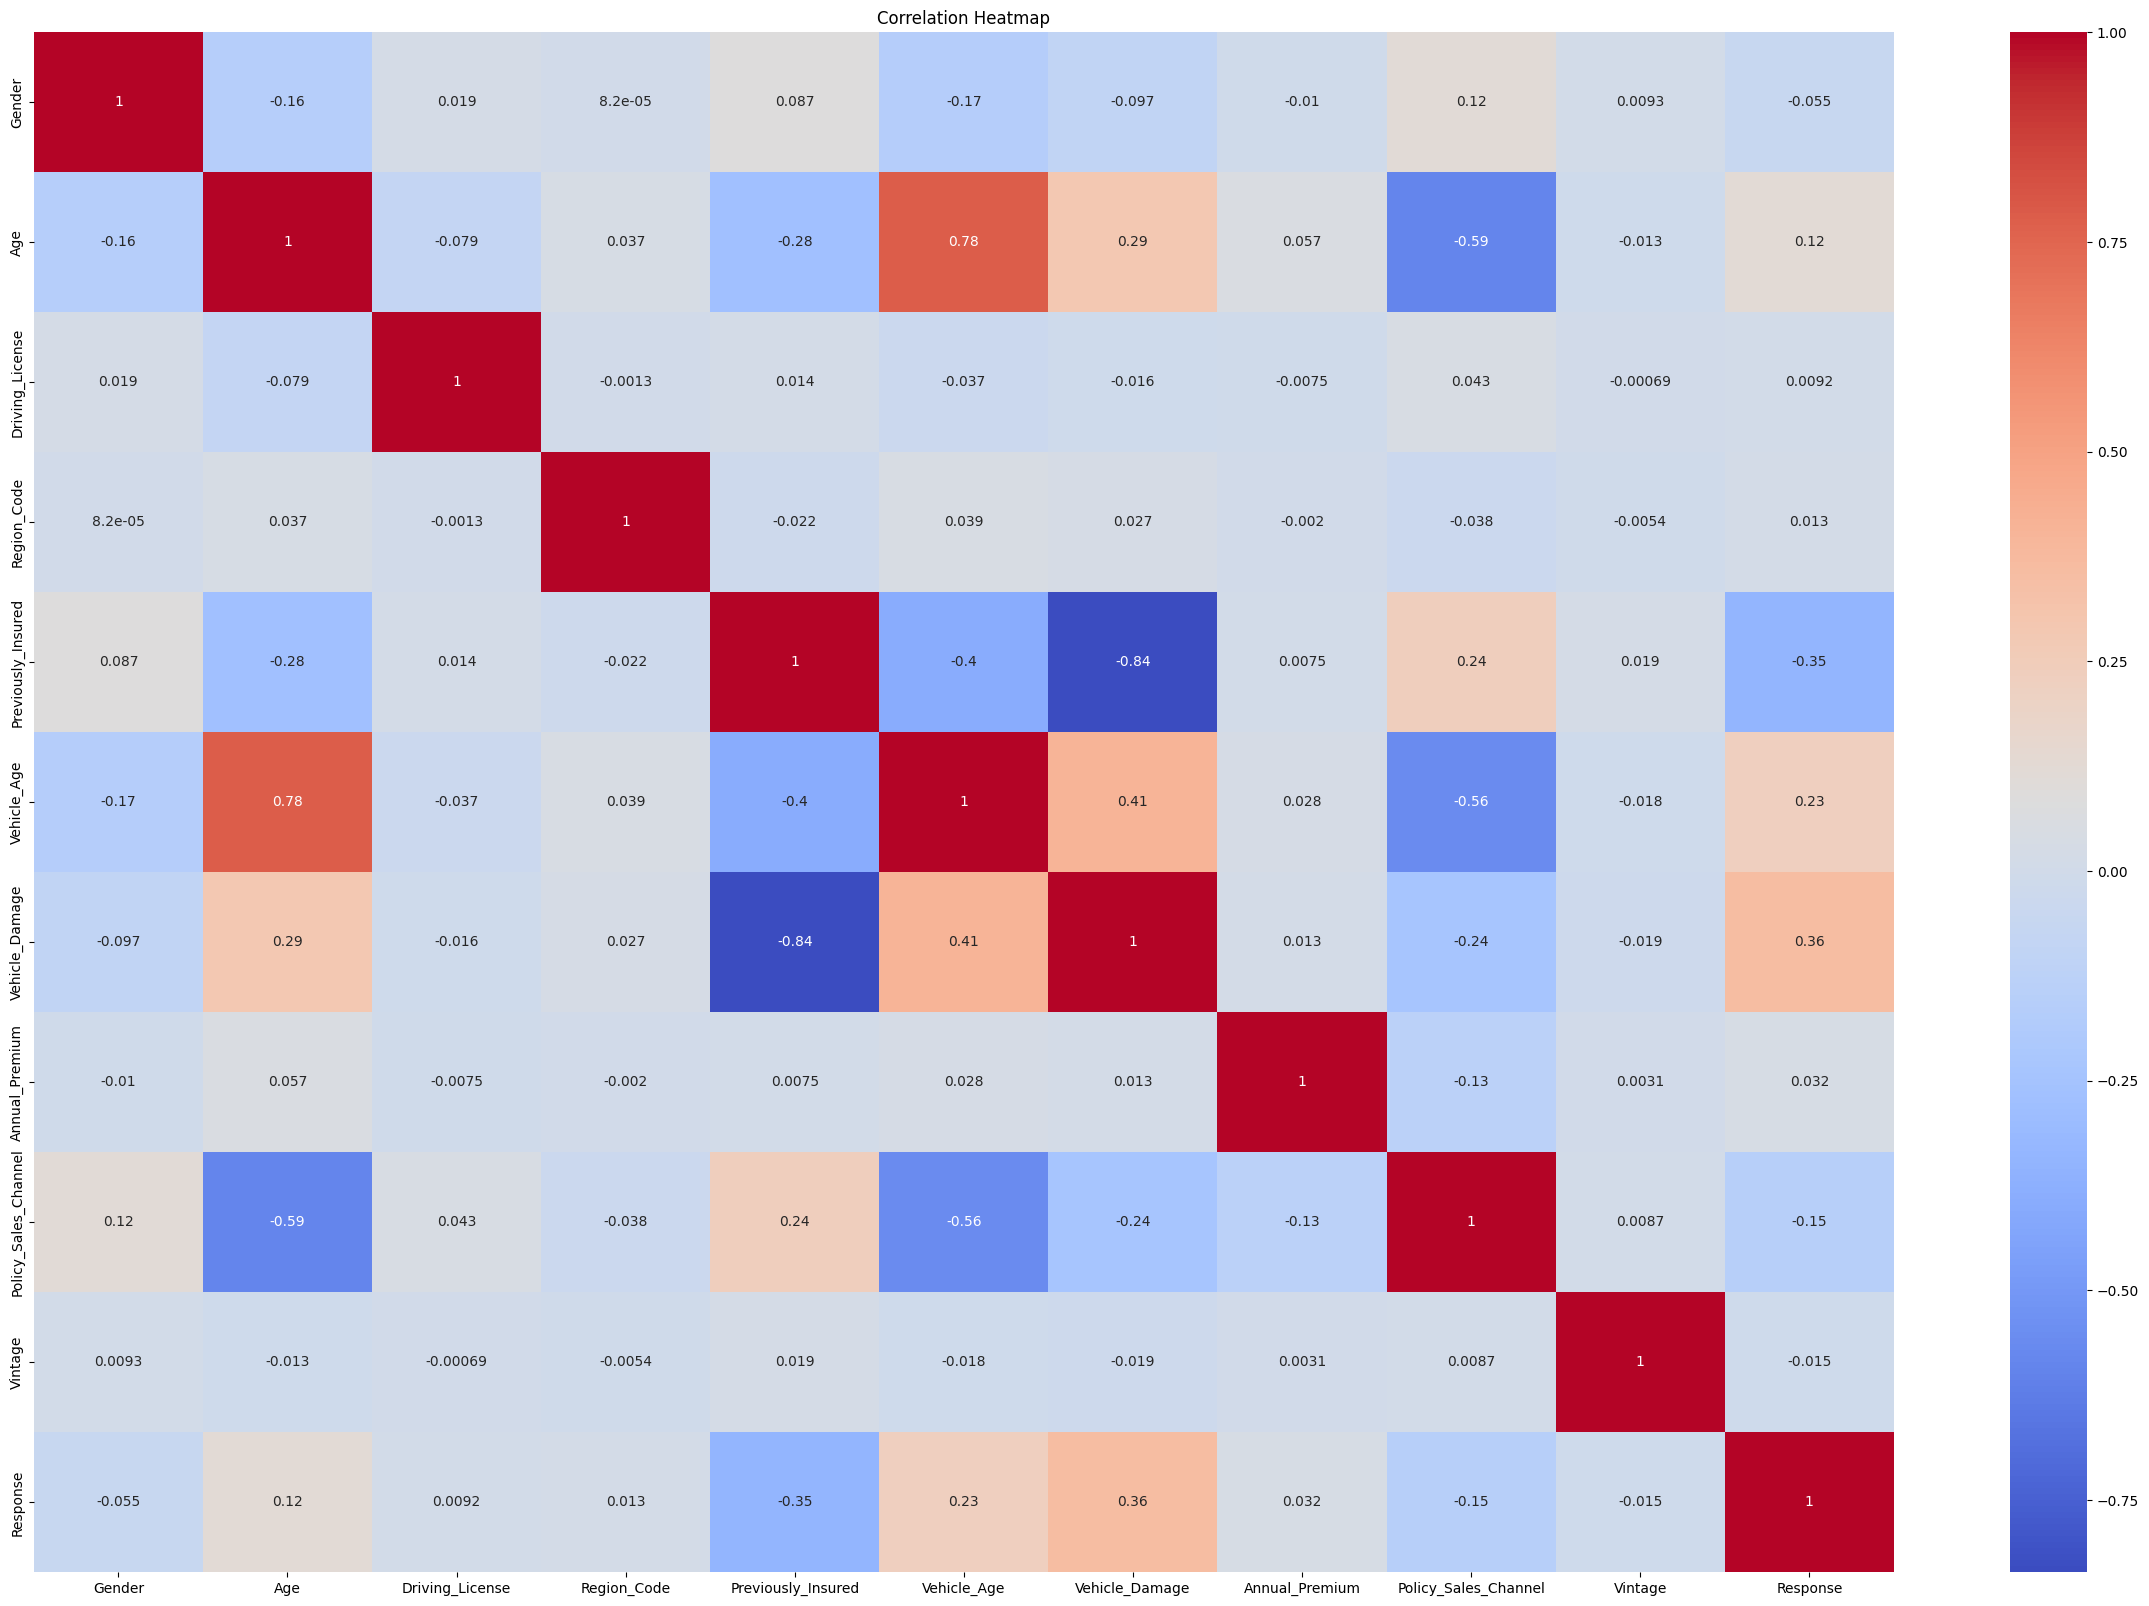

In [24]:
plt.figure(figsize=(30, 20))
sns.heatmap(pd.DataFrame(
                train_df_subset, 
                columns=train_df_subset.columns).corr(), 
                annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# XGBoost - (AUC: 0.894)

In [25]:
X = train_df_subset.drop(columns=['Response'])
y = train_df_subset['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.20, 
                                                    stratify = y, 
                                                    random_state=42)

In [26]:
xgb_best_params = {
                  'max_depth': 10,
                  'min_child_weight': 8,
                  'gamma': 0.001,
                  'eta': 0.03,
                  'n_estimators': 5000,
                  'subsample': 0.85,
                  'colsample_bytree': 0.8,
                  'scale_pos_weight': negative/positive,
                  'tree_method': 'hist'
}

gc.collect()

xgb_opt = XGBClassifier(**xgb_best_params,
                          objective = 'binary:logistic',
                          random_state=0)

In [27]:
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.03, eval_metric=None,
              feature_types=None, gamma=0.001, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=8, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5000,
              n_jobs=None, num_parallel_tree=None, ...)

In [28]:
y_pred =  xgb_opt.predict(X_test)

## Model Eval

In [29]:
target_names = ['Responded No', 'Responded Yes']

# classification report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

 Responded No       0.98      0.72      0.83   2084828
Responded Yes       0.31      0.90      0.46    292354

     accuracy                           0.74   2377182
    macro avg       0.65      0.81      0.65   2377182
 weighted avg       0.90      0.74      0.79   2377182



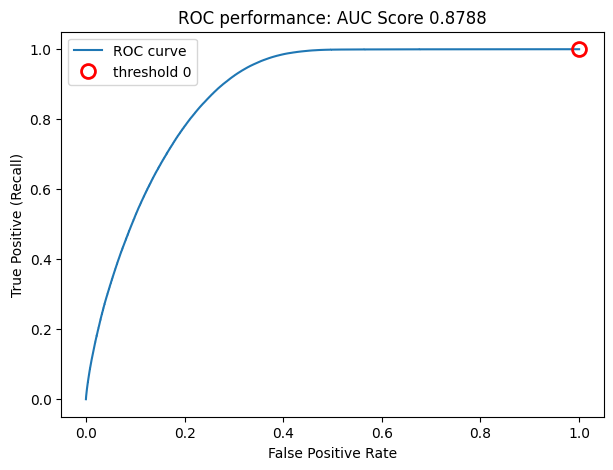

In [30]:
# probability results
proba_ = xgb_opt.predict_proba(X_test)[:, 1]

# eval metrics
precision, recall, thresholds = precision_recall_curve(y_test, proba_)
fp, tp, thresholds_roc = roc_curve(y_test, proba_)

auc_score = np.round(roc_auc_score(y_test, proba_), 4)    

close_default = np.argmin(np.abs(thresholds - 0.5))
close_zero = np.argmin(np.abs(thresholds_roc))

# Plot ROC Curve
plt.figure(figsize=(7, 5))

plt.plot(fp, tp, label="ROC curve")
plt.plot(fp[close_zero], 
         tp[close_zero], 'o', 
         c='r', markersize=10, 
         label='threshold 0', 
         fillstyle="none", mew=2)
plt.title(f"ROC performance: AUC Score {auc_score}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive (Recall)")
plt.legend(loc='best')   

plt.show()   

In [31]:
y_pred_prob =  xgb_opt.predict_proba(test_df)[:,1]

In [32]:
submission_df = pd.DataFrame({'id': test_df.index, 
                              'Response':y_pred_prob})

In [33]:
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,Response
0,11504798,0.010901
1,11504799,0.847294
2,11504800,0.698702
3,11504801,0.000666
4,11504802,0.374275




<center><img src="https://cdn.prod.website-files.com/646218c67da47160c64a84d5/64634be786d11debe86c8c42_86.png" width=200 height=200 /></center>